

Stage 1: Bottleneck Identification Notebook
------------------------------------------------



## 1. Imports

In this first step, we load all necessary libraries and modules:

- **pandas** (`pd`): for data loading and manipulation.
- **numpy** (`np`): for numerical operations and array handling.
- **matplotlib.pyplot** (`plt`): for creating static visualizations.
- **seaborn** (`sns`): for enhanced statistical graphics.
- **scipy.cluster.hierarchy** (`linkage`, `dendrogram`): for hierarchical clustering and dendrogram plotting.
- **sklearn.preprocessing** (`StandardScaler`): for feature scaling prior to distance calculations.
- **sklearn.cluster** (`AgglomerativeClustering`, `DBSCAN`, `KMeans`):
  - `AgglomerativeClustering`: hierarchical clustering method.
  - `DBSCAN`: density-based clustering fallback.
  - `KMeans`: for inertia-based elbow analysis.
- **sklearn.metrics** (`silhouette_score`, `silhouette_samples`, `davies_bouldin_score`, `calinski_harabasz_score`, `pairwise_distances`):
  - Cluster validation metrics and distance computations.

We also attempt to import **tslearn.metrics** for Dynamic Time Warping (DTW); if unavailable, we proceed without DTW functionality.


In [45]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score,
    pairwise_distances
)

# Try DTW
try:
    from tslearn.metrics import cdist_dtw
    DTW_AVAILABLE = True
except ImportError:
    DTW_AVAILABLE = False


## 2. Data Loading & Cleaning
In this section, we:

1. **Load** the raw Maggi production dataset from an Excel file, parsing the start and end date‑time columns.
2. **Verify** that all essential columns are present; raise an error if any are missing.
3. **Clean** the data by dropping rows missing the key "Bottleneck Duration Seconds" value.
4. **Classify** each event as active (`1`) or non‑active (`0`) based on the "Stoppage Category".

- `FILEPATH`: Path to your Excel file.
- `pd.read_excel`: Loads and parses the specified date columns.
- `required` check: Ensures critical fields exist before proceeding.
- `df.dropna`: Removes incomplete duration records.
- `df['is_active']`: Creates a binary flag for downstream analysis.

In [46]:

# Data Loading & Cleaning
FILEPATH = r"C:\Users\pbrin\Downloads\DATA WIP SORTED BASED ON ACTIVE STATE.xlsx"
df = pd.read_excel(FILEPATH, parse_dates=['Start Datetime','End Datetime'])

# Ensure essential columns
required = ['Line','Stoppage Category','Stoppage Reason','Shift Id','Bottleneck Duration Seconds']
for c in required:
    if c not in df.columns:
        raise KeyError(f"Missing column: {c}")

# Drop missing durations
df = df.dropna(subset=['Bottleneck Duration Seconds'])

# Classify active event
df['is_active'] = (df['Stoppage Category']!='Not Occupied').astype(int)


## 3. Advanced Preprocessing

Before clustering, we apply the following steps to improve data quality:

1. **Outlier Removal (IQR Method)**:
   - Compute the 1st (Q1) and 3rd (Q3) quartiles of the "Bottleneck Duration Seconds".
   - Calculate the interquartile range (IQR = Q3 − Q1).
   - Retain only those observations within [Q1 − 1.5×IQR, Q3 + 1.5×IQR], eliminating extreme values that could skew clustering.

2. **Optional Smoothing (Rolling Median)**:
   - For time-series stability, you can smooth each line’s bottleneck durations using a rolling median (window size = 5).
   - This reduces noise and highlights sustained bottleneck patterns.

These preprocessing steps help ensure clusters reflect meaningful operational behaviors rather than artifacts or one-off spikes.

In [47]:

# 3. Advanced Preprocessing
# Remove extreme outliers using IQR
Q1 = df['Bottleneck Duration Seconds'].quantile(0.25)
Q3 = df['Bottleneck Duration Seconds'].quantile(0.75)
IQR = Q3 - Q1
mask = df['Bottleneck Duration Seconds'].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
df = df[mask]

# (Optional) Smooth durations with rolling median per group
# df['Bottleneck_Smooth'] = df.groupby(['Line'])['Bottleneck Duration Seconds'].transform(lambda x: x.rolling(5,center=True,min_periods=1).median())


## 4. Summary Statistics & Time‑Series Extraction

In this step, we transform the cleaned data into two key structures:

1. **Summary Statistics (`stats` DataFrame):**
   - Groups: each unique combination of `Line`, `Stoppage Reason`, and `Shift Id`.
   - Aggregations on `Bottleneck Duration Seconds`:
     - `mean`, `std`, `min`, `max` for central tendency and dispersion.
     - `count` (renamed to `length`) for the number of events in each group.
   - The resulting `stats` DataFrame provides a compact feature set for clustering.

2. **Time-Series Dictionary (`ts_dict`):**
   - For each group with more than one event, we extract the raw sequence of bottleneck durations sorted by start time.
   - This dictionary maps `(Line, Stoppage Reason, Shift Id)` keys to NumPy arrays of durations.
   - These series can later be used for DTW-based distance computations or visual inspections.

By combining statistical summaries and raw time-series, we enable both Euclidean and DTW clustering approaches.

In [48]:

# 4. Summary & Time-Series Extraction
# Summary stats per (Line,Reason,Shift)
stats = df.groupby(['Line','Stoppage Reason','Shift Id'])['Bottleneck Duration Seconds'] \
    .agg(['mean','std','min','max','count']) \
    .rename(columns={'count':'length'}) \
    .dropna()

# time-series dict for DTW if needed
ts_dict = {key:grp.sort_values('Start Datetime')['Bottleneck Duration Seconds'].values
           for key,grp in df.groupby(['Line','Stoppage Reason','Shift Id'])
           if len(grp)>1}


## 5. Distance Matrices

In this section, we compute two complementary distance matrices to capture similarity:

1. **Euclidean Distance on Summary Statistics**:
   - Standardize the `stats` feature matrix using `StandardScaler`.
   - Compute the pairwise Euclidean distances between all group feature vectors.
   - Stores result in `D_euc` for use in clustering and heatmaps.

2. **Dynamic Time Warping (DTW) Distance on Time-Series** (optional):
   - If `tslearn` is installed (`DTW_AVAILABLE = True`), compute DTW distances between each raw bottleneck duration series in `ts_dict`.
   - Stores result in `D_dtw`, allowing alignment-based clustering of temporal patterns.

These distance matrices enable both shape-based (DTW) and magnitude-based (Euclidean) clustering approaches.

In [49]:

# Euclidean on scaled stats
scaler = StandardScaler()
X = scaler.fit_transform(stats.values)
D_euc = pairwise_distances(X,metric='euclidean')

# DTW distance if available
if DTW_AVAILABLE:
    X_ts = list(ts_dict.values())
    D_dtw = cdist_dtw(X_ts)
else:
    D_dtw = None

### 5b. Distance Matrix Heatmap

Visualize the Euclidean distance matrix as a heatmap to identify blocks of similar group behaviors:

- **sns.heatmap**: displays pairwise distances with a color gradient (`viridis`).
- **Dark squares** along the diagonal indicate clusters of groups with low inter-group distances.
- **Lighter regions** show group pairs that are dissimilar.

This plot helps visually confirm the number of cohesive clusters before formal clustering.

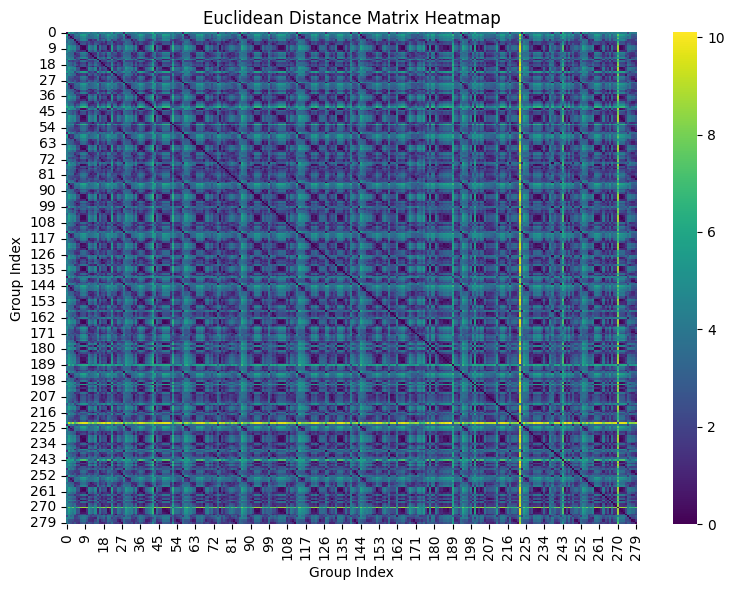

In [50]:
# %%
# 5b. Distance Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(D_euc, cmap='viridis')
plt.title('Euclidean Distance Matrix Heatmap')
plt.xlabel('Group Index')
plt.ylabel('Group Index')
plt.tight_layout()
plt.show()


### 5c. Elbow Plot (KMeans WCSS)
The Elbow Method helps determine the optimal number of clusters by plotting the **Within-Cluster Sum of Squares (WCSS)** (also known as inertia) against different values of k:

- **WCSS (inertia)**: measures the total squared distance between each point and the centroid in its cluster. Lower inertia indicates tighter clusters.
- As k increases, inertia decreases because points are closer to their own centroids.
- Look for the “elbow” point where the rate of decrease sharply changes—this suggests a balance between compact clusters and model simplicity.

In this plot, we iterate k from 1 to 10, fit a `KMeans` model, record its `inertia_`, and visualize the curve to identify the optimal k.

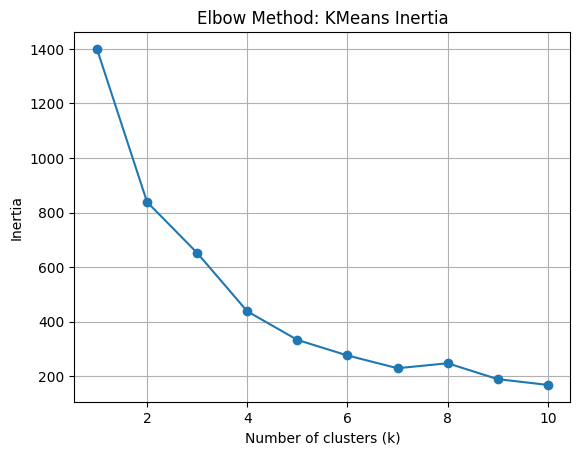

In [51]:
# %%
# 5c. Elbow Plot (KMeans WCSS)
wcss = []
ks = range(1,11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    wcss.append(km.inertia_)
plt.figure()
plt.plot(ks, wcss, marker='o')
plt.title('Elbow Method: KMeans Inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

### 5d Visualization Helpers

We define reusable plotting functions to streamline our visual analysis:

- **`plot_dendrogram(Z)`**: Generates a dendrogram from a linkage matrix `Z`:
  - **`figsize=(10,5)`** ensures readability.
  - **`color_threshold=0`** draws all clusters in a single color for clarity.
  - Labels the axes (`Group index`, `Distance`) and titles the chart.

Additional helper functions (e.g., silhouette curve, time-series plotting) can be defined here to keep the main notebook cells concise.

In [52]:
# 5d. Visualization helpers

def plot_dendrogram(Z):
    plt.figure(figsize=(10, 5))
    dendrogram(Z, color_threshold=0)
    plt.title('Dendrogram: AHC (Complete Linkage)')
    plt.xlabel('Group index')
    plt.ylabel('Distance')
    plt.show()


## 6. Parameter Tuning for AHC

In this step, we identify the optimal number of clusters (k) for Agglomerative Hierarchical Clustering (AHC) using silhouette analysis:

1. **Iterate** k from 2 to 7.
2. **Fit** an AHC model with `metric='precomputed'` and `linkage='complete'` on the Euclidean distance matrix (`D_euc`).
3. **Compute** the average silhouette score for each k to assess cluster cohesion and separation.
4. **Store** results in `sil_df` and **plot** silhouette vs. k to visually identify the best cluster count.
5. **Select** `opt_k` as the k value with the highest silhouette score for final clustering.

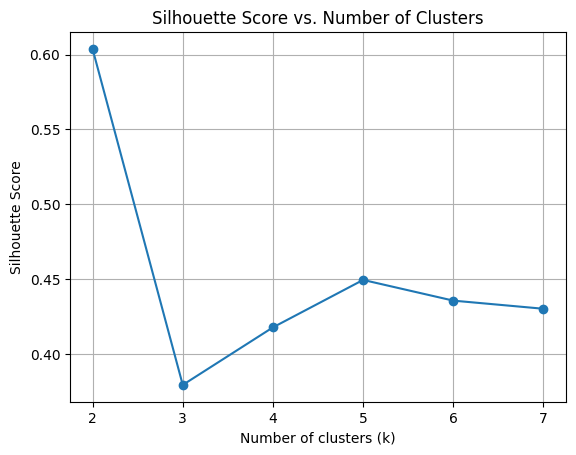

Optimal clusters by silhouette: 2


In [53]:
# %%
# 6. Parameter Tuning for AHC
sil_scores = []
for k in range(2,8):
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    labels = model.fit_predict(D_euc)
    sil = silhouette_score(D_euc, labels, metric='precomputed')
    sil_scores.append({'k':k,'silhouette':sil})
sil_df = pd.DataFrame(sil_scores)

plt.figure()
plt.plot(sil_df['k'], sil_df['silhouette'], marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Choose optimal k
opt_k = sil_df.loc[sil_df['silhouette'].idxmax(),'k']
print(f"Optimal clusters by silhouette: {opt_k}")

# 6. Density-based clustering via DBSCAN (HDBSCAN proxy)

def run_dbscan(D: np.ndarray, eps: float, min_samples: int = 5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = db.fit_predict(D)
    return labels


## 7. Clustering Execution

With the optimal cluster count (`opt_k`) determined, we perform our final clustering methods:

1. **Agglomerative Hierarchical Clustering (AHC)**
   - Compute the linkage matrix `Z` using complete linkage on the Euclidean distance matrix (`D_euc`).
   - Fit the AHC model with `n_clusters=opt_k`, `metric='precomputed'`, and `linkage='complete'` to generate `labels_ahc`.

2. **Density-Based Clustering (HDBSCAN / DBSCAN fallback)**
   - Attempt to import and fit **HDBSCAN** with `metric='precomputed'` and `min_cluster_size=10` to generate `labels_hdb`.
   - If **HDBSCAN** is unavailable, fall back to **DBSCAN**, setting `eps` to the median value of `D_euc` and `min_samples=5`.

These cluster labels (`labels_ahc` and `labels_hdb`) will be used in the next evaluation step.

In [54]:
# %%
# 7. Clustering Execution
# AHC with optimal k
Z = linkage(D_euc, method='complete')
labels_ahc = AgglomerativeClustering(
    n_clusters=int(opt_k), metric='precomputed', linkage='complete'
).fit_predict(D_euc)

# HDBSCAN or DBSCAN
try:
    import hdbscan
    labels_hdb = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=10).fit_predict(D_euc)
except ImportError:
    labels_hdb = DBSCAN(eps=np.median(D_euc),min_samples=5,metric='precomputed').fit_predict(D_euc)

C:\Users\pbrin\AppData\Local\Temp\ipykernel_14048\1379624814.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D_euc, method='complete')


## 8. Evaluation Metrics

We now validate cluster quality using three internal metrics:

- **Silhouette Score**: Evaluates how well each data point fits within its assigned cluster vs. the next best one (−1 to +1, higher is better).
- **Davies–Bouldin Index**: Captures average similarity between each cluster and its most similar one (lower is better).
- **Calinski–Harabasz Index**: Reflects the ratio of between-cluster dispersion to within-cluster dispersion (higher is better).

We implement `compute_metrics` to:
1. Compute the silhouette score using the precomputed distance matrix (`D_euc`).
2. Compute DB and CH scores on the standardized features (`X`).

Then, we compare metrics for both the hierarchical clusters (`labels_ahc`) and density-based clusters (`labels_hdb`) to determine which method yields more coherent groupings.

In [55]:
# %%
# 8. Evaluation Metrics

def compute_metrics(labels, D, X):
    m = {}
    m['silhouette'] = silhouette_score(D, labels, metric='precomputed') if len(set(labels))>1 else np.nan
    mask = labels>=0
    m['db'] = davies_bouldin_score(X[mask], labels[mask]) if len(set(labels[mask]))>1 else np.nan
    m['ch'] = calinski_harabasz_score(X[mask], labels[mask]) if len(set(labels[mask]))>1 else np.nan
    return m

metrics = pd.DataFrame({
    'AHC': compute_metrics(labels_ahc, D_euc, X),
    'Density': compute_metrics(labels_hdb, D_euc, X)
}).T

print(metrics)


         silhouette        db         ch
AHC        0.603797  0.546669  29.505457
Density    0.643044       NaN        NaN


## 9. Visualizations

In this section, we create two primary plots to evaluate our clustering results:

1. **Dendrogram (Agglomerative Clustering)**
   - Visualizes the hierarchical merging of clusters based on linkage distance.
   - Use it to confirm the chosen number of clusters and identify well-separated groupings.

2. **Silhouette Plot (AHC)**
   - Shows the silhouette coefficient for each group, organized by cluster.
   - The silhouette coefficient measures how similar an object is to its own cluster compared to other clusters (range: -1 to +1).
   - A red dashed line indicates the average silhouette score, providing a benchmark for overall clustering quality.

These visualizations help you assess cluster cohesion, separation, and identify any outliers or misclassified groups.

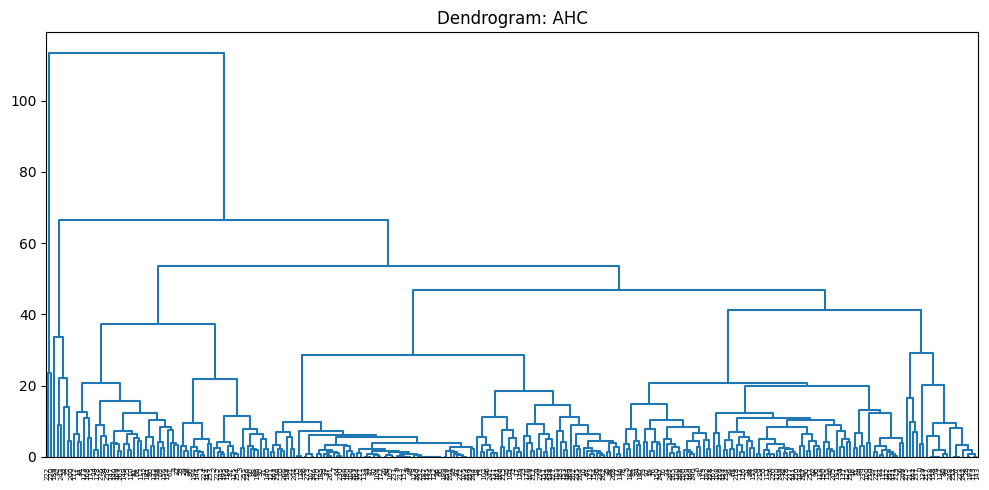

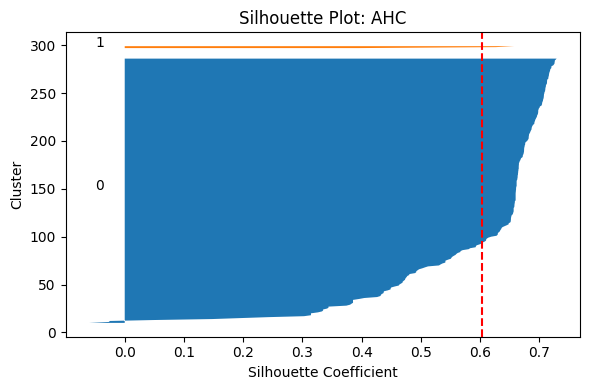

In [56]:
# %%
# 9. Visualizations
# Dendrogram
plt.figure(figsize=(10,5))
_ = dendrogram(Z, color_threshold=0)
plt.title('Dendrogram: AHC')
plt.tight_layout()
plt.show()

# Silhouette plot for AHC
sample_sil = silhouette_samples(D_euc, labels_ahc, metric='precomputed')
fig, ax1 = plt.subplots(1,1, figsize=(6,4))
ax1.set_title('Silhouette Plot: AHC')
ax1.set_xlabel('Silhouette Coefficient')
ax1.set_ylabel('Cluster')
y_lower = 10
for i in range(int(opt_k)):
    ith_sil = sample_sil[labels_ahc==i]
    ith_sil.sort()
    size = ith_sil.shape[0]
    y_upper = y_lower + size
    ax1.fill_betweenx(np.arange(y_lower,y_upper), 0, ith_sil)
    ax1.text(-0.05, y_lower + 0.5*size, str(i))
    y_lower = y_upper + 10
ax1.axvline(x=metrics.loc['AHC','silhouette'], color="red", linestyle="--")
plt.tight_layout()
plt.show()


## 10. Clustered Time-Series Samples

To visually validate the temporal coherence within each cluster, we plot sample bottleneck duration series for the first three clusters:

1. **Select** up to 5 representative time-series from each cluster (`labels_ahc`).
2. **Overlay** these series in a single plot, using semi-transparent lines (`alpha=0.7`).
3. **Observe** common patterns such as repeated spikes, flat periods, or consistent run-times within each cluster.

This visual check ensures that clusters capture similar dynamic behaviors, confirming that the grouping makes operational sense.

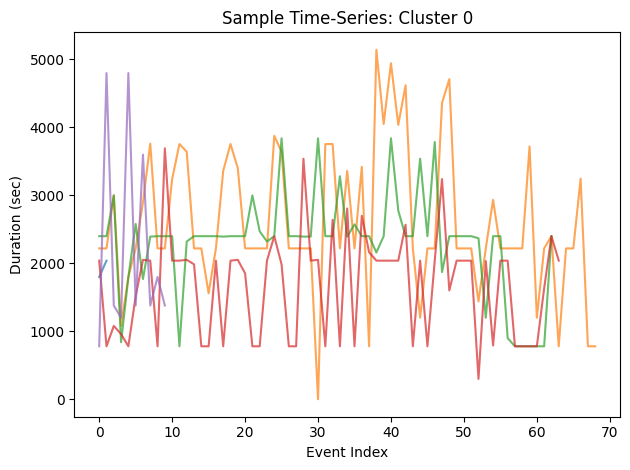

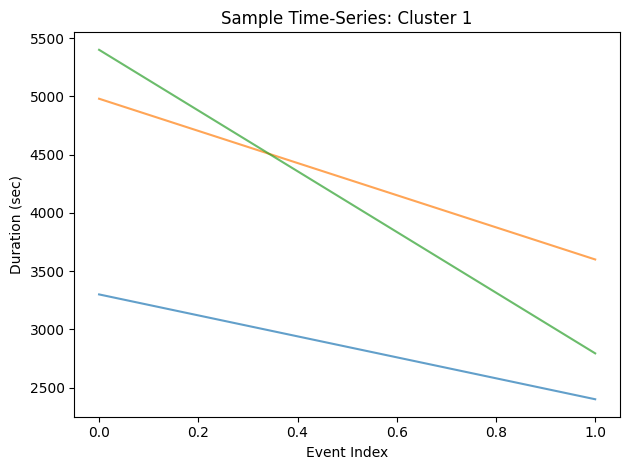

In [57]:
# %%
# 10. Clustered Time-Series Samples (first 3 clusters)
for cluster_id in range(min(3,int(opt_k))):
    plt.figure()
    plt.title(f"Sample Time-Series: Cluster {cluster_id}")
    keys = [k for k,l in zip(ts_dict.keys(),labels_ahc) if l==cluster_id]
    for key in keys[:5]:
        plt.plot(ts_dict[key], alpha=0.7)
    plt.xlabel('Event Index')
    plt.ylabel('Duration (sec)')
    plt.tight_layout()
    plt.show()

## 11. Export Results

In this final step, we persist our clustering outputs for further use and reporting:

1. **Annotate** the `stats` DataFrame with cluster labels:
   - `AHC_label` for hierarchical clustering results.
   - `Density_label` for density-based clustering results.
2. **Export** key artifacts:
   - **`clustering_metrics_stage1.csv`**: a CSV file containing the performance metrics for each clustering method.
   - **`cluster_assignments_stage1.csv`**: a CSV file with the original `stats` plus cluster labels for each group.
3. **Confirmation**: print a message indicating successful export.
"""

In [58]:
# %%
# 11. Export Results
stats['AHC_label'] = labels_ahc
stats['Density_label'] = labels_hdb
metrics.to_csv('clustering_metrics_stage1.csv')
stats.to_csv('cluster_assignments_stage1.csv')
print("Exports complete.")

Exports complete.
